## Imports

In [1]:
import pathlib
import os
import os.path as osp
import sys
import argparse
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero

from utils.gnn_simple import Model
from utils.train_test import train_test
from utils.visualize import plot_loss, plot_train, plot_val, plot_test

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read the dataset

In [3]:
path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLens')
dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

#### Preprocess the dataset

In [4]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

#### Define and train-test the model

In [5]:
model = Model(
    data,
    layer_name="SAGE",
    encoder_num_layers=5,
    encoder_dropout=0.1,
    encoder_skip_connections=True,
    decoder_num_layers=4,
    hidden_channels=32
).to(device)
losses = train_test(
    model=model,
    epochs=30,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data
)

c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\environ\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 001, Loss: 20.1467, Train: 3.4604, Val: 3.4605, Test: 3.4814
Epoch: 002, Loss: 18.6206, Train: 2.8588, Val: 2.8618, Test: 2.8806
Epoch: 003, Loss: 12.8856, Train: 1.1062, Val: 1.1115, Test: 1.1030
Epoch: 004, Loss: 8.0020, Train: 1.7155, Val: 1.7305, Test: 1.7209
Epoch: 005, Loss: 6.5141, Train: 1.8389, Val: 1.8749, Test: 1.8734
Epoch: 006, Loss: 7.0656, Train: 1.4461, Val: 1.4691, Test: 1.4976
Epoch: 007, Loss: 6.1079, Train: 1.1167, Val: 1.1282, Test: 1.1246
Epoch: 008, Loss: 6.7409, Train: 1.3534, Val: 1.3411, Test: 1.3675
Epoch: 009, Loss: 6.0612, Train: 1.6263, Val: 1.6649, Test: 1.6832
Epoch: 010, Loss: 6.3584, Train: 1.6774, Val: 1.6597, Test: 1.6820
Epoch: 011, Loss: 6.3389, Train: 1.4026, Val: 1.4304, Test: 1.4297
Epoch: 012, Loss: 5.9000, Train: 1.1626, Val: 1.1818, Test: 1.1923
Epoch: 013, Loss: 6.1344, Train: 1.2229, Val: 1.2312, Test: 1.2439
Epoch: 014, Loss: 6.0754, Train: 1.4485, Val: 1.4657, Test: 1.4800
Epoch: 015, Loss: 5.8333, Train: 1.5724, Val: 1.5763, Test:

#### Visualize

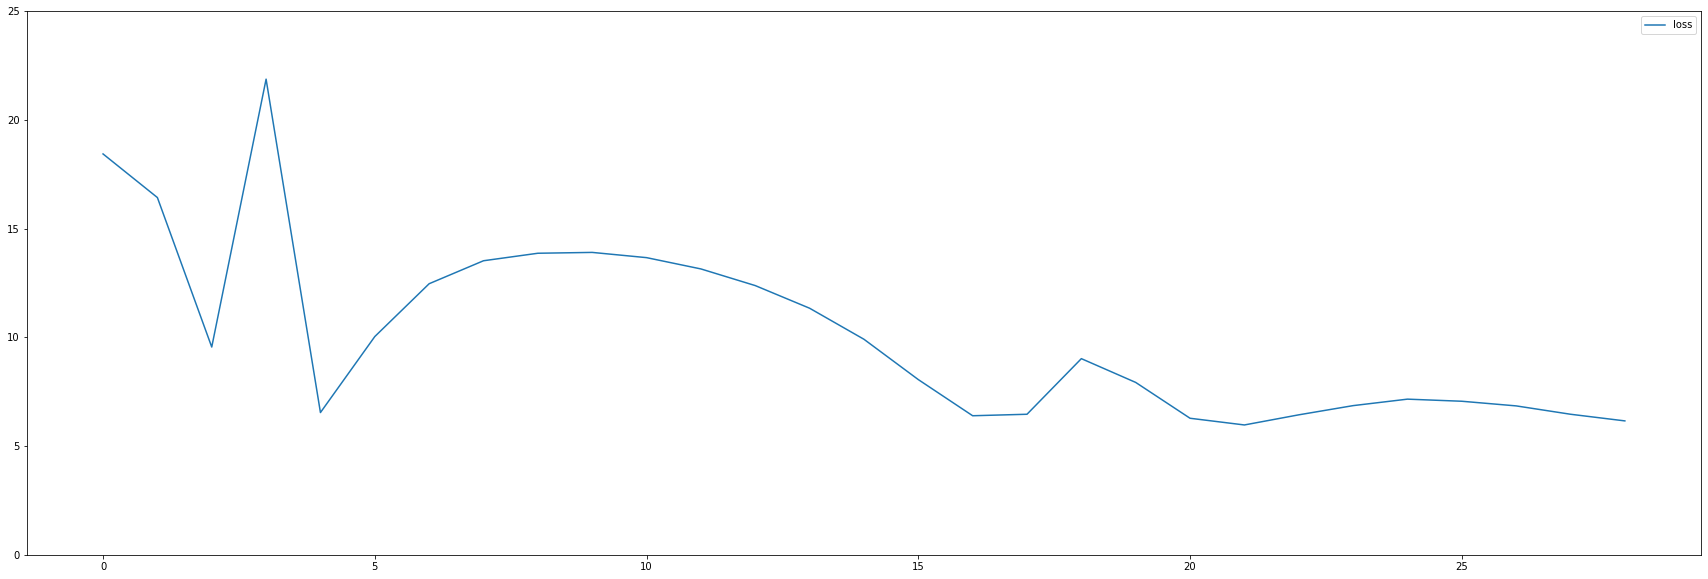

In [7]:
plot_loss({ "loss": losses }, ylim=25)